In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Natural Language Inference


## 0. Library 설치

In [ ]:
!pip install transformers==4.41.2 evaluate==0.4.0 datasets==2.20.0 scikit-learn==1.4.2
!pip install accelerate -U
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 83.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.4
    Uninstalling tokeniz

## 1. Code

### 1) 데이터셋 로드

In [ ]:
from datasets import load_dataset, DatasetDict
import pandas as pd

dataset = load_dataset('klue', 'nli')
print(dataset)
print(f"샘플: {dataset['train'][0]}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/24998 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
        num_rows: 24998
    })
    validation: Dataset({
        features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
        num_rows: 3000
    })
})
샘플: {'guid': 'klue-nli-v1_train_00000', 'source': 'NSMC', 'premise': '힛걸 진심 최고다 그 어떤 히어로보다 멋지다', 'hypothesis': '힛걸 진심 최고로 멋지다.', 'label': 0}


### 2) EDA

label list: ['entailment', 'neutral', 'contradiction']
id2label: {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
label2id: {'entailment': 0, 'neutral': 1, 'contradiction': 2}
train 데이터셋의 Premise: 0
train 데이터셋의 Hypothesis: 0
train 데이터셋의 Label: 0
validation 데이터셋의 Premise: 0
validation 데이터셋의 Hypothesis: 0
validation 데이터셋의 Label: 0


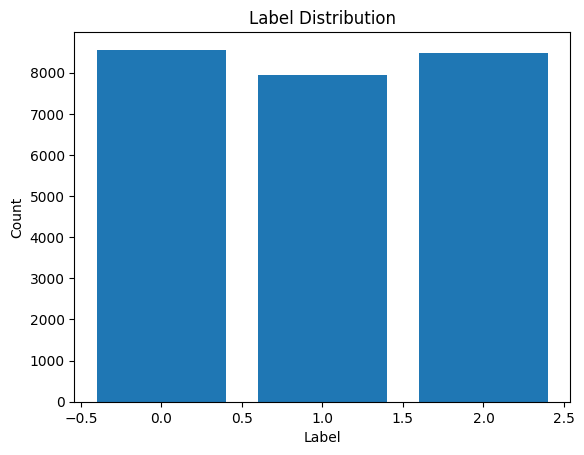

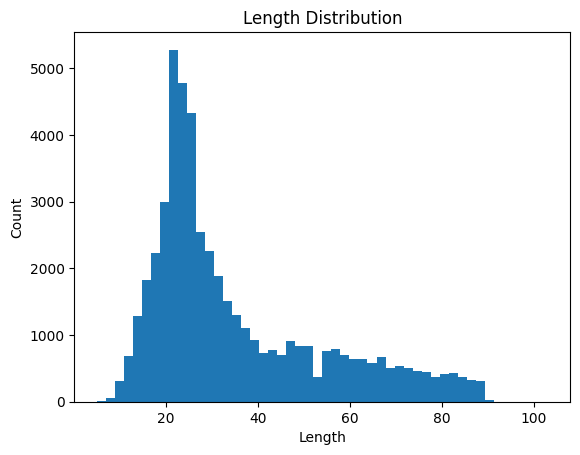

최대 길이: 103
평균 길이: 35.16549323945916
최소 길이: 5


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

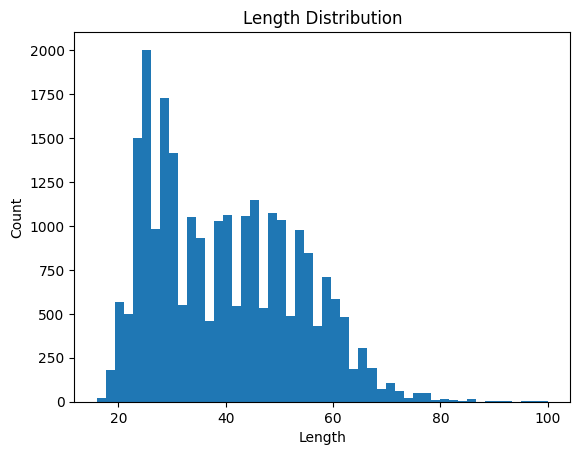

최대 길이: 100
평균 길이: 40.02904232338587
최소 길이: 16


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 2.1 텍스트, 레이블 컬럼 지정 및 레이블 리스트, id2label, label2id
PREM_COL, HYP_COL, LABEL_COL = 'premise', 'hypothesis', 'label'
label_list = dataset['train'].features[LABEL_COL].names
print(f"label list: {label_list}")
id2label = {i: l for i, l in enumerate(label_list)}
label2id = {l: i for i, l in enumerate(label_list)}
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")

# 2.2 텍스트, 레이블 결측치 확인
for split in dataset:
    df = pd.DataFrame(dataset[split])
    missing_premise = df[PREM_COL].isna().sum() + (df[PREM_COL].astype(str).str.strip() == '').sum()
    missing_hypothesis = df[HYP_COL].isna().sum() + (df[HYP_COL].astype(str).str.strip() == '').sum()
    missing_label = df[LABEL_COL].isna().sum()
    print(f"{split} 데이터셋의 Premise: {missing_premise}")
    print(f"{split} 데이터셋의 Hypothesis: {missing_hypothesis}")
    print(f"{split} 데이터셋의 Label: {missing_label}")

# 2.3 레이블 분포
train_labels = dataset['train'][LABEL_COL]
label_counts = np.unique(train_labels, return_counts=True)
plt.bar(label_counts[0], label_counts[1])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

# 2.4 문자 길이 분포
text_lengths = [len(x) for x in dataset['train'][PREM_COL] + dataset['train'][HYP_COL]]
plt.hist(text_lengths, bins=50)
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Length Distribution')
plt.show()

print(f"최대 길이: {max(text_lengths)}")
print(f"평균 길이: {np.mean(text_lengths)}")
print(f"최소 길이: {min(text_lengths)}")

# 2.5 토큰화가 된 후의 문자 길이 분포
from transformers import AutoTokenizer
MODEL_NAME = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
lengths = [len(tokenizer.encode(x[PREM_COL], text_pair=x[HYP_COL])) for x in dataset['train']]
plt.hist(lengths, bins=50)
plt.xlabel('Length')
plt.ylabel('Count')
plt.title('Length Distribution')
plt.show()

print(f"최대 길이: {max(lengths)}")
print(f"평균 길이: {np.mean(lengths)}")
print(f"최소 길이: {min(lengths)}")

### 3) Preprocessing

In [ ]:
from transformers import AutoTokenizer, DataCollatorWithPadding

# 3.1 결측치 처리: text NaN/빈문장 제거
def not_empty(ex, text_cols=[PREM_COL, HYP_COL]):
    for col in text_cols:
        s = ex.get(col, None)
        if s is None:
            return False
        if len(str(s).strip()) == 0:
            return False

    return True

dataset = dataset.filter(not_empty)
print(dataset)

# 3.2 토크나이저 및 collator 정의
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"tokenizer: {tokenizer}")
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 3.3 데이터 분할
split_data = dataset['train'].train_test_split(test_size=0.2, seed=42)
dataset = DatasetDict({
    'train': split_data['train'],
    'validation': split_data['test'],
    'test': dataset['validation']
})
print(f"분할 후 데이터셋: {dataset}")

# 3.4 토크나이저 함수 정의
MAX_LEN = 128
def tokenize_func(examples):
    return tokenizer(examples[PREM_COL], text_pair=examples[HYP_COL], truncation=True, max_length=MAX_LEN)

tokenized = dataset.map(tokenize_func, batched=True, remove_columns=['guid', 'source', 'premise', 'hypothesis'])
print(f"tokenized dataset: {tokenized}")

Filter:   0%|          | 0/24998 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
        num_rows: 24998
    })
    validation: Dataset({
        features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
        num_rows: 3000
    })
})
tokenizer: BertTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False

Map:   0%|          | 0/19998 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

tokenized dataset: DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 19998
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
})


### 4) 모델 및 학습 설정

In [ ]:
from transformers import AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(label_list), id2label=id2label, label2id=label2id)
print(f"Model: {model}")

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print(f"No GPU available, using the CPU instead.")

model.to(device)
print(f"Model: {model}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

### 5) 데이터 로더 설정

In [ ]:
print(f"학습 데이터: {tokenized['train']}")
print(f"검증 데이터: {tokenized['validation']}")
print(f"테스트 데이터: {tokenized['test']}")

학습 데이터: Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 19998
})
검증 데이터: Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5000
})
테스트 데이터: Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3000
})


In [ ]:
from torch.utils.data import DataLoader

def _to_dataloader(dataset, collator, batch_size, shuffle=False):
    return DataLoader(
        dataset,
        collate_fn=collator,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=True,
    )

train_loader = _to_dataloader(tokenized['train'], collator, batch_size=64, shuffle=True)
valid_loader = _to_dataloader(tokenized['validation'], collator, batch_size=64, shuffle=False)
test_loader = _to_dataloader(tokenized['test'], collator, batch_size=32, shuffle=False)

print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

313
79
94


In [ ]:
print(19998/64, 5000/64, 3000/32)

312.46875 78.125 93.75


### 6) 학습

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

epochs = 5

/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm

def metrics(preds, labels):
    """
    분류 모델의 성능을 평가하는 메트릭을 계산하는 함수.

    Parameters:
    - predictions: 모델에 의해 예측된 레이블의 배열, 모든 예측값은 실제 레이블과 같은 형태를 가진다.
    - labels: 실제 레이블의 배열, 각 요소는 정답 클래스를 나타낸다.

    Returns:
    - metrics: 모델의 성능을 나타내는 딕셔너리
      - 'accuracy': 모델의 정확도. 모든 예측 중 정확한 예측의 비율.
      - 'f1_macro': F1 점수의 매크로 평균. 클래스별로 F1 Score를 계산한 뒤, 평균을 냄, 각 클래스에 동일한 가중치를 부여
      - 'f1_micro': F1 점수의 마이크로 평균. 전체 데이터에서 TP, FP, FN을 합산한 뒤 F1 계산
      - 'f1_weighted': F1 점수의 가중 평균. 클래스별로 F1 Score를 계산한 뒤, 각 클래스의 샘플 수로 가중치

    메트릭 설명:
    - 정확도(accuracy): 모든 예측 중 정확하게 예측된 비율. 전체적인 모델의 정확성을 나타낸다.
    - F1 점수: 정밀도(precision)와 재현율(recall)의 조화 평균. 클래스 간의 균형을 고려한 성능 지표.
      - 매크로 평균(macro average): 각 클래스에 대한 F1 점수를 동일하게 취급하고, 이들의 평균을 계산.
      - 마이크로 평균(micro average): 전체적인 TP(True Positive), FP(False Positive), FN(False Negative)을 고려하여 F1 점수를 계산.
      - 가중치 평균(weighted average): 각 클래스의 샘플 수를 가중치로 사용하여 F1 점수를 계산.
    """
    y_pred = preds
    y_true = labels

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'f1_weighted': f1_weighted
    }

In [ ]:
def train(model, train_loader, optimizer, device):
    """
    한 번의 에포크 동안 모델을 학습시키는 함수입니다.

    Parameters:
    model (torch.nn.Module): 학습할 모델
    train_loader (torch.utils.data.DataLoader): 학습 데이터 로더
    optimizer (torch.optim.Optimizer): 옵티마이저
    device (torch.device): 학습 장치 (CPU or GPU)

    Returns:
    train_loss (float): 에포크 동안의 평균 학습 손실값
    """

    total_train_loss = 0
    model.train()

    for step, batch in tqdm(enumerate(train_loader), desc='Training Batch'):
        batch = {k: v.to(device) for k, v in batch.items()}
        b_input_ids = batch['input_ids']
        b_input_mask = batch['attention_mask']
        b_labels = batch['labels']

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        # 손실값 추출
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    return avg_train_loss

def evaluate(model, valid_loader, device):
    """
    모델을 사용하여 검증 데이터셋에 대한 평가를 수행하는 함수입니다.

    Parameters:
    model (torch.nn.Module): 평가할 모델
    valid_loader (torch.utils.data.DataLoader): 검증 데이터 로더
    device (torch.device): 평가 장치 (CPU or GPU)

    Returns:
    eval_loss (float): 검증 손실값
    eval_metrics: 모델의 성능 지표
    """
    model.eval()

    total_eval_loss = 0
    preds, labels = [], []

    for batch in valid_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        b_input_ids = batch['input_ids']
        b_input_mask = batch['attention_mask']
        b_labels = batch['labels']

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

        if outputs.loss is not None:
            loss = outputs.loss
            total_eval_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        preds.extend(np.argmax(logits, axis=-1).flatten())
        labels.extend(label_ids.flatten())

    eval_metrics = metrics(preds, labels)

    return total_eval_loss / len(valid_loader), eval_metrics

In [ ]:
min_val_loss = float('inf')

for epoch in range(epochs):
    print('========== Epoch {:} / {:} =========='.format(epoch + 1, epochs))

    # 학습 단계
    train_loss = train(model, train_loader, optimizer, device)
    print(f"Epoch{epoch + 1} Train Loss: {train_loss:.2f}")

    # 검증 단계
    avg_val_loss, val_metrics = evaluate(model, valid_loader, device)
    print(f"Validation Loss: {avg_val_loss:.2f}")
    print(f"Accuracy: {val_metrics['accuracy']:.2f}")
    print(f"Precision: {val_metrics['precision']:.2f}")
    print(f"Recall: {val_metrics['recall']:.2f}")
    print(f"Macro F1: {val_metrics['f1_macro']:.2f}")
    print(f"Micro F1: {val_metrics['f1_micro']:.2f}")
    print(f"Weighted F1: {val_metrics['f1_weighted']:.2f}")

    if avg_val_loss < min_val_loss:
        print(f"Validation loss decreased ({min_val_loss:.2f} -> {avg_val_loss:.2f}). Saving model ...")
        torch.save(model.state_dict(), './nli_model_pytorch.pt')
        min_val_loss = avg_val_loss

========== Epoch 1 / 5 ==========


Training Batch: 313it [03:46,  1.38it/s]


Epoch1 Train Loss: 0.09
Validation Loss: 0.69
Accuracy: 0.82
Precision: 0.82
Recall: 0.82
Macro F1: 0.82
Micro F1: 0.82
Weighted F1: 0.82
Validation loss decreased (inf -> 0.69). Saving model ...
========== Epoch 2 / 5 ==========


Training Batch: 313it [03:46,  1.38it/s]


Epoch2 Train Loss: 0.06
Validation Loss: 0.75
Accuracy: 0.82
Precision: 0.82
Recall: 0.82
Macro F1: 0.82
Micro F1: 0.82
Weighted F1: 0.82
========== Epoch 3 / 5 ==========


Training Batch: 313it [03:46,  1.38it/s]


Epoch3 Train Loss: 0.06
Validation Loss: 0.83
Accuracy: 0.82
Precision: 0.82
Recall: 0.81
Macro F1: 0.81
Micro F1: 0.82
Weighted F1: 0.82
========== Epoch 4 / 5 ==========


Training Batch: 313it [03:45,  1.39it/s]


Epoch4 Train Loss: 0.05
Validation Loss: 0.84
Accuracy: 0.82
Precision: 0.82
Recall: 0.82
Macro F1: 0.82
Micro F1: 0.82
Weighted F1: 0.82
========== Epoch 5 / 5 ==========


Training Batch: 313it [03:45,  1.39it/s]


Epoch5 Train Loss: 0.04
Validation Loss: 0.84
Accuracy: 0.83
Precision: 0.83
Recall: 0.82
Macro F1: 0.82
Micro F1: 0.83
Weighted F1: 0.83


### 7) 모델 로드 및 평가

In [ ]:
model.load_state_dict(torch.load('./nli_model_pytorch.pt'))

avg_test_loss, test_metrics = evaluate(model, test_loader, device)
print(f"Test Loss: {avg_test_loss:.2f}")
print(f"Accuracy: {test_metrics['accuracy']:.2f}")
print(f"Precision: {test_metrics['precision']:.2f}")
print(f"Recall: {test_metrics['recall']:.2f}")
print(f"Macro F1: {test_metrics['f1_macro']:.2f}")
print(f"Micro F1: {test_metrics['f1_micro']:.2f}")
print(f"Weighted F1: {test_metrics['f1_weighted']:.2f}")

Test Loss: 0.81
Accuracy: 0.78
Precision: 0.78
Recall: 0.78
Macro F1: 0.78
Micro F1: 0.78
Weighted F1: 0.78


### 8) 추론하기

In [ ]:
from transformers import pipeline

pipe = pipeline('text-classification', model=model.cuda(), tokenizer=tokenizer, device=0, function_to_apply='softmax')
inputs = {
    'text': "서울은 대한민국의 수도이다.",
    'text_pair': "서울은 한국의 수도다."
}
print("\n[DEMO]")
print(pipe(inputs))


[DEMO]
{'label': 'entailment', 'score': 0.9985974431037903}
